# NN tryouts on SPR data, inspired by Kaggle Forum "When less is more"


- Load m month of data
- Minimal data cleaning
- Feature engineering

- Setup model

TRAIN : 201505, 201506

- FEATURES <- get_profile(ALL_FEATURES) : Select some profiles

- Train on all users
- Select only users that added products in 201506 comparing to 201505


month data is like [FEATURES|TARGETS]

X_train = [FEATURES] of the training part
Y_train = [TARGETS]  of the training part

X_val = [FEATURES] of the validation part
Y_val = [TARGETS]  of the validation part

TEST :
201606
- All users
[FEATURES]
X_test = [FEATURES]

In [63]:
import os
import numpy as np
import pandas as pd

import logging
logging.getLogger().handlers = []
logging.basicConfig(level=logging.DEBUG)

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
from common import load_data2, minimal_clean_data_inplace, preprocess_data_inplace, TARGET_LABELS
from common import get_added_products, remove_last_choice, apk

In [3]:
TRAIN_FILE_PATH = os.path.join("..", "data", "train_ver2.csv")
TEST_FILE_PATH = os.path.join("..", "data", "test_ver2.csv")

Load data + minimal cleaning + preprocessing

* 201505 - to get the clients last choice 
* 201506 - to train on

In [4]:
yearmonth_list = [201505, 201506] 
nb_months = len(yearmonth_list)
nb_clients = 100000

In [5]:
data_df = load_data2(TRAIN_FILE_PATH, yearmonth_list, nb_clients)
minimal_clean_data_inplace(data_df)
preprocess_data_inplace(data_df)

months = data_df['fecha_dato'].unique()
clients = data_df['ncodpers'].unique()
assert len(clients) == (data_df['ncodpers'].value_counts() == nb_months).sum()
ll = len(clients)
for m in months:
    l = len(data_df[data_df['fecha_dato'] == m]['ncodpers'].unique())
    assert l == ll, "Number of clients should be identical for all monthes. (%s, %s, %s)" % (m, l, ll)

INFO:root:-- Select 100000 clients
INFO:root:- Number of lines with unknown data : 606
INFO:root:- Number of columns with nan : 9


In [6]:
features = [
    u'ind_empleado', u'pais_residencia',
    u'sexo', u'age', u'ind_nuevo', u'antiguedad', u'indrel',
    u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
    u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'nomprov',
    u'ind_actividad_cliente', u'renta', u'segmento'    
]

last_choice_mask = data_df['fecha_dato'] == months[-2]
train_month_mask = data_df['fecha_dato'] == months[-1]

Create profiles and create models for profiles

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Merge
from keras.utils import np_utils

Using Theano backend.


# Train on all clients

In [ ]:
profiles = {
     0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],
     8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
#      11: ['nomprov', 'ind_nuevo', 'antiguedad', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

def create_model():
    ll = len(TARGET_LABELS)
    final_model = Sequential()
    models = []
    for key in profiles:
        length = len(profiles[key])
        model = Sequential()
        model.add(Dense(2*length + 15, init='uniform', input_shape=(length,), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(10 + length, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(ll, activation='softmax'))
        models.append(model)

    merged = Merge(models, mode='sum')
    final_model.add(merged)
    final_model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return final_model

In [ ]:
clients_last_choice = data_df[last_choice_mask][['ncodpers'] + TARGET_LABELS]
X = data_df[train_month_mask][['ncodpers'] + features]
Y = data_df[train_month_mask][TARGET_LABELS]
n_highest = 7

def map7_score(y, clients, y_pred):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    gb = clients_last_choice.groupby('ncodpers')
    map7 = 0.0

    for i, client, targets in zip(range(len(y)), clients, y):
        last_choice = gb.get_group(client)[TARGET_LABELS].values[0].astype(np.uint)
        added_products = get_added_products(targets, last_choice)
        predictions = remove_last_choice(predicted_added_products[i], last_choice)
        score = apk(added_products, predictions)    
        map7 += score    

    map7 /= len(y)
    logging.info('-- Predicted map7 score: {}'.format(map7))
    return map7

In [ ]:
# CROSS VALIDATION
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def cross_val_score(x_df, y_df, nb_folds=3):
    
    kf = KFold(n_splits=nb_folds)
    scores = []
    y = y_df.values
    clients = x_df['ncodpers'].values
    for train_index, test_index in kf.split(y):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        Y_train, Y_val = y[train_index], y[test_index]
        C_train, C_val = clients[train_index], clients[test_index]
        logging.info("- Train/Val shapes : {}, {} | {}, {}".format(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape))

        x_train = []
        x_val = []

        for key in profiles:
            x_train_ = X_train[profiles[key]].values
            x_val_ = X_val[profiles[key]].values    
            x_train_ = StandardScaler().fit_transform(x_train_)
            x_val_ = StandardScaler().fit_transform(x_val_)  

            x_train.append(x_train_)
            x_val.append(x_val_)

        logging.info("- Create the model")
        estimator = create_model()
        logging.info("- Fit the model")
        hist = estimator.fit(x_train, Y_train, nb_epoch=50, batch_size=20000, verbose=0)        
        for key in hist.history:            
            logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
        
        logging.info("- Predict using trained model")
        Y_pred = estimator.predict(x_val, verbose=0)
        logging.info("- Compute map7 score")
        scores.append(map7_score(Y_val, C_val, Y_pred))
    
    return np.array(scores)

nb_folds=5
results = cross_val_score(X, Y, nb_folds=nb_folds)
print "Cross-Validation (%i folds)  : %f | %.5f" % (nb_folds, results.mean(), results.std())

### Test 1 :  

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 10000


#### Model

- merged profiles with 'sum', softmax, categorical_crossentropy, nadam, accuracy, 

**Conf:**
- Profiles : 0, 8
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50 | 5 | 0.028340 | 0.00510
150  | 5 | 0.028542 | 0.00479


**Conf:**
- Profiles : 0,1,2,3,4,5,6,7,8,9
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50 | 5 | 0.028247 | 0.00465
150  | 5 | 0.028353 | 0.00488


**Conf:**
- Profiles : 0, 9
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50 | 5 | 0.028189 | 0.00566
150  | 5 | 0.028577 | 0.00490

================================================================

#### Model

- merged profiles with 'ave', sigmoid, categorical_crossentropy, rmsprop, accuracy, 

**Conf:**
- Profiles : 0, 9
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50 | 5 | 0.025520 | 0.00592
150  | 5 | 0.028201 | 0.00501


================================================================

#### Model

- merged profiles with 'sum', sigmoid, categorical_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 9
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50 | 5 | 0.028362 | 0.00499
150  | 5 | 0.027777 | 0.00471


================================================================

#### Model

- merged profiles with 'ave', sigmoid, categorical_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 9
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50  | 5 | 0.027978 | 0.00571
150 | 5 | 0.027958 | 0.00469


**Conf:**
- Profiles : 0, 1
- batch_size=10000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50  | 5 | 0.024595 | 0.00232
100 | 5 | 0.027853 | 0.027853
150 | 5 | 0.028253 | 0.00519
250 | 5 | 0.028294 | 0.00544

**Conf:**
- Profiles : 0, 1
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50  | 5 | 0.028515 | 0.00506
100 | 5 | 0.028245 | 0.00512
150 | 5 | 0.028515 | 0.00494
250 | 5 | 0.028334 | 0.00466


**Conf:**
- Profiles : 0, 1, 2
- batch_size=10000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50  | 5 | 0.025003 | 0.00509
100 | 5 | 0.027886 | 0.00522 
150 | 5 | 0.028463 | 0.00469
250 | 5 | 0.028321 | 0.00467

**Conf:**
- Profiles : 0, 1, 2
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50  | 5 | 0.027873 | ?
150 | 5 | 0.027589 | 0.00513 

================================================================

### Test 2 :  

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 100000


#### Model

- merged profiles with 'sum', softmax, categorical_crossentropy, nadam, accuracy, 

**Conf:**
- Profiles : 0, 8 
- batch_size=20000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
50 | 5 | 0.027462 | 0.00470
150  | 5 | 0.027563 | 0.00448




## Select only clients that choose new products in 201506 comparing with 201505

201505 [FEATURES|TARGETS]  
201506 [FEATURES|TARGETS]  

TARGETS_201505 -> clients_last_choice
TARGETS_201506 - TARGETS_201505 -> active_clients

Cross-validation : 
FEATURES_201506 -> (Split train/val) :
  --> (0.75*FEATURES) -> (select only active clients) -> X_train
  --> 0.25*FEATURES -> X_val



In [8]:
trainval_df = data_df.sort_values(['fecha_dato', 'ncodpers'])
last_choice_mask = trainval_df['fecha_dato'] == months[-2]
train_month_mask = trainval_df['fecha_dato'] == months[-1]

In [306]:
def add_diff_inplace(df, last_choice_mask, train_month_mask):
    tmp_df = df[['fecha_dato','ncodpers']]
    tmp_df.loc[:,'target'] = df[TARGET_LABELS].sum(axis=1)
    v1 = tmp_df[train_month_mask]['target'].values
    v2 = tmp_df[last_choice_mask]['target'].values
    ll = min(len(v1), len(v2))
    indices = tmp_df.index[ll:]
    df.loc[indices,'diff'] = pd.Series(v1 - v2, index=indices)
    del tmp_df, v1, v2

In [11]:
add_diff_inplace(trainval_df, last_choice_mask, train_month_mask)
print trainval_df.shape
trainval_df.sort_values(['ncodpers', 'fecha_dato']).head(10)

(199394, 47)


,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1,diff
421297,2015-05-28,15894,0,22,1,59.0,1995-01-16,0,244,1.0,...,0,0,1,1,1,0,1.0,1.0,1,NaN
1053309,2015-06-28,15894,0,22,1,59.0,1995-01-16,0,245,1.0,...,0,0,1,1,1,0,1.0,1.0,1,0.0
421302,2015-05-28,15901,2,22,1,55.0,1995-01-16,0,244,1.0,...,0,0,0,1,1,0,0.0,0.0,1,NaN
1053303,2015-06-28,15901,2,22,1,55.0,1995-01-16,0,245,1.0,...,0,0,0,1,1,0,0.0,0.0,1,-1.0
421303,2015-05-28,15902,1,22,0,57.0,1995-01-16,0,244,1.0,...,0,0,0,0,0,0,0.0,0.0,0,NaN
1053302,2015-06-28,15902,1,22,0,57.0,1995-01-16,0,245,1.0,...,0,0,0,0,0,0,0.0,0.0,0,0.0
421308,2015-05-28,15911,2,22,1,52.0,1995-01-16,0,244,1.0,...,0,0,0,1,1,0,0.0,0.0,1,NaN
1053297,2015-06-28,15911,2,22,1,52.0,1995-01-16,0,245,1.0,...,0,0,0,1,1,0,0.0,0.0,1,0.0
421291,2015-05-28,15918,1,22,0,50.0,1995-01-16,0,244,1.0,...,0,1,0,1,0,0,1.0,1.0,1,NaN
1053331,2015-06-28,15918,1,22,0,50.0,1995-01-16,0,245,1.0,...,0,1,0,1,0,0,1.0,1.0,1,0.0


In [187]:
clients_last_choice = trainval_df[last_choice_mask][['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
X = trainval_df[train_month_mask][['ncodpers', 'diff'] + features]
Y = trainval_df[train_month_mask][['ncodpers'] + TARGET_LABELS]

In [188]:
# Select only clients from test data
clients_last_choice = clients_last_choice[clients_last_choice['ncodpers'].isin(X['ncodpers'])]
assert (X['ncodpers'] == clients_last_choice['ncodpers']).all(), "WTF"

### Feature engineering

In [189]:
def get_age_group_index(age):
    if age < 10:
        return -3
    elif age < 15:
        return -2        
    elif age < 18:
        return -1    
    elif age < 23:
        return 0
    elif age < 25:
        return 1
    elif age < 27:
        return 2
    elif age < 28:
        return 3    
    elif age < 32:
        return 4
    elif age < 37:
        return 5    
    elif age < 42:
        return 6
    elif age < 47:
        return 7
    elif age < 52:
        return 8
    elif age < 57:
        return 9
    elif age < 60:
        return 10
    elif age < 65:
        return 11
    elif age < 70:
        return 12
    elif age < 75:
        return 13
    elif age < 80:
        return 14
    else:
        return 15

def get_income_group_index(income):
    if income < 0:
        return -1
    elif income < 45542.97:
        return 1
    elif income < 57629.67:
        return 2
    elif income < 68211.78:
        return 3
    elif income < 78852.39:
        return 4
    elif income < 90461.97:
        return 5
    elif income < 103855.23:
        return 6
    elif income < 120063.00:
        return 7
    elif income < 141347.49:
        return 8
    elif income < 173418.36:
        return 9
    elif income < 234687.12:
        return 10
    else:
        return 11

In [190]:
X.loc[:,'age'] = X['age'].apply(get_age_group_index)
X.loc[:,'renta'] = X['renta'].apply(get_income_group_index)

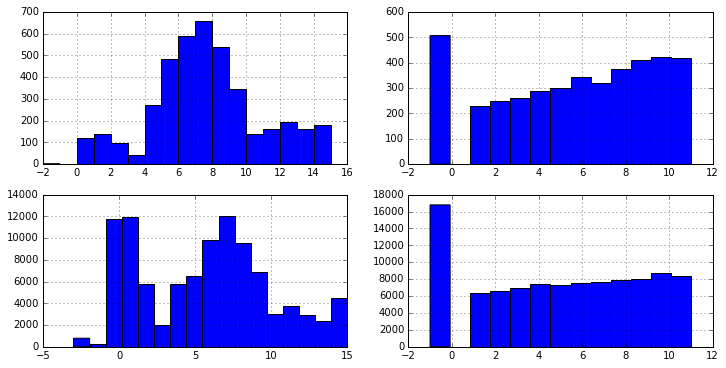

In [191]:
mask = X['diff'] > 0

plt.figure(figsize=(12,6))
plt.subplot(221)
X[mask]['age'].hist(bins=17)
plt.subplot(222)
X[mask]['renta'].hist(bins=13)
plt.subplot(223)
X['age'].hist(bins=17)
plt.subplot(224)
X['renta'].hist(bins=13)

Separate young people from other due to different train/val distributions

In [192]:
mask = X['age'].isin([0, 1, 2]) 
mask_clients = X[mask]['ncodpers']
X_1 = X[mask]
Y_1 = Y[mask]
X = X[~mask]
Y = Y[~mask]
mask = clients_last_choice['ncodpers'].isin(mask_clients)
clients_last_choice_1 = clients_last_choice[mask]
clients_last_choice = clients_last_choice[~mask]

### Run KFold Cross-validation 

In [294]:
young_profiles = {
     0: ['renta', 'nomprov', 'ind_actividad_cliente', 'antiguedad'],
#      0: ['renta', 'nomprov', 'antiguedad'],    
#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],
     8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
#      11: ['nomprov', 'ind_nuevo', 'antiguedad', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

other_profiles = {
     0: ['pais_residencia', 'sexo', 'age', 'ind_nuevo', 'segmento', 'ind_empleado', 'ind_actividad_cliente', 'indresi'],
#      1: ['pais_residencia', 'sexo', 'age', 'segmento', 'nomprov'],
#      2: ['pais_residencia', 'sexo', 'age', 'segmento', 'antiguedad'],
#      3: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo'],
#      4: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_actividad_cliente'],
#      5: ['pais_residencia', 'sexo', 'age', 'segmento', 'canal_entrada'],
#      6: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_nuevo', 'canal_entrada'],
#      7: ['pais_residencia', 'sexo', 'age', 'segmento', 'ind_empleado'],
     8: ['pais_residencia', 'sexo', 'age', 'segmento', 'renta'],
#      9: ['sexo', 'age', 'segmento'],    
#      10: ['sexo', 'age', 'segmento', 'ind_actividad_cliente']
     11: ['nomprov', 'ind_nuevo', 'antiguedad', 'renta', 'ind_actividad_cliente', 'canal_entrada']
}

profiles = young_profiles

In [295]:
def create_model():
    ll = len(TARGET_LABELS)
    final_model = Sequential()
    models = []
    for key in profiles:
        length = len(profiles[key])
        model = Sequential()
        model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(10 + length, activation='relu'))
        model.add(Dropout(0.15))
        model.add(Dense(ll, activation='sigmoid'))
        models.append(model)

    merged = Merge(models, mode='ave')
    final_model.add(merged)
    final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return final_model

In [296]:
n_highest = 7
def map7_score2(y, y_pred, clients_last_choice, n_highest=7):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    map7 = 0.0

    for last_choice, targets, products in zip(clients_last_choice, y, predicted_added_products):
        added_products = get_added_products(targets, last_choice)
        predictions = remove_last_choice(products, last_choice)
        score = apk(added_products, predictions)    
        map7 += score            

    map7 /= len(y)
    logging.info('-- Predicted map7 score: {}'.format(map7))
    return map7

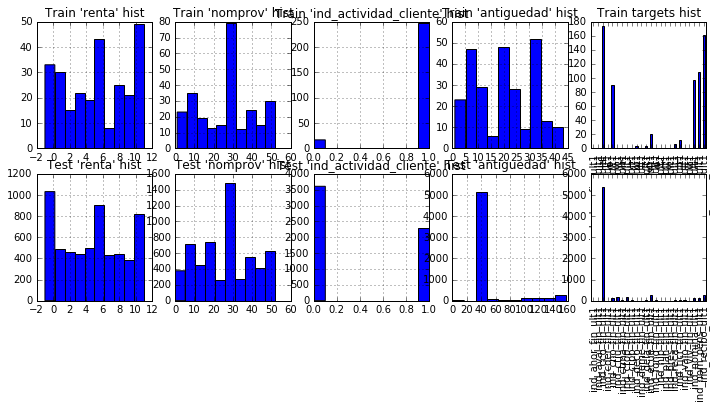

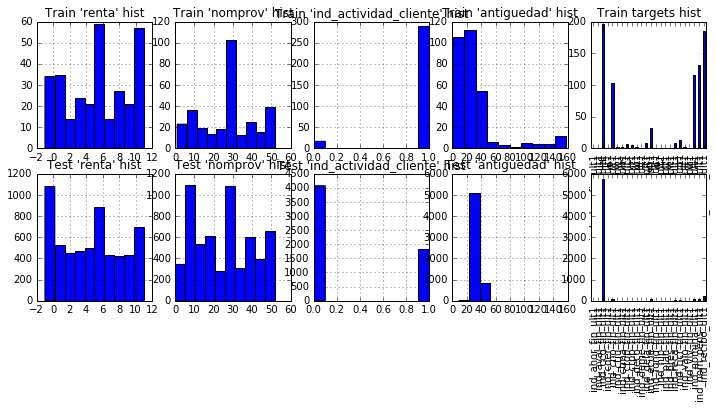

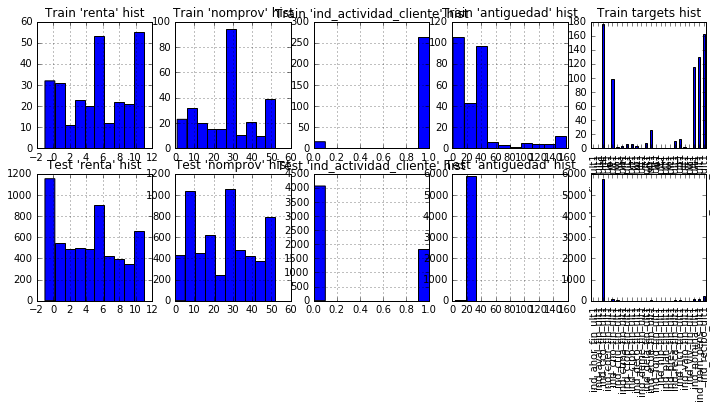

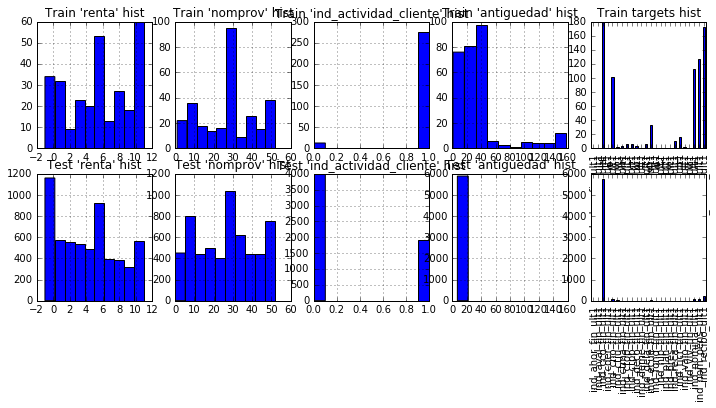

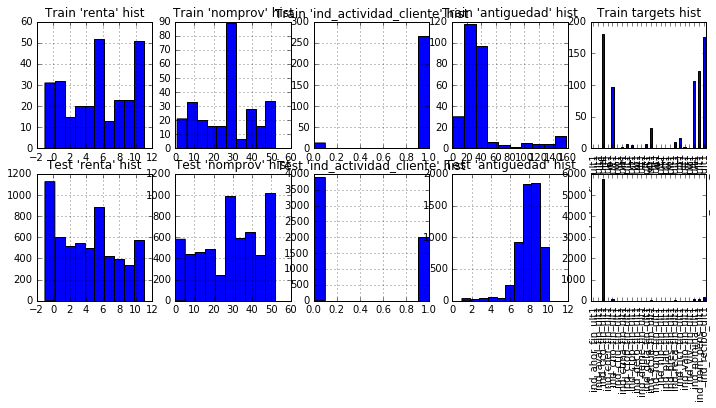

In [335]:
from sklearn.model_selection import KFold

nb_folds=5


def visualize_train_test(X_train, X_test, profile, Y_train=None, Y_test=None):
    plt.figure(figsize=(12,5))        
    ll = len(profile)
    if Y_train is not None and Y_test is not None:
        ll += 1
    
    for i, feature in enumerate(profile):
        plt.subplot(2,ll, i+1)
        plt.title("Train '%s' hist" % (feature))
        X_train[feature].hist()
        
        plt.subplot(2,ll, ll + i + 1)
        plt.title("Test '%s' hist" % (feature))
        X_test[feature].hist()

    if Y_train is not None and Y_test is not None:
        plt.subplot(2, ll, ll)
        plt.title("Train targets hist")
        Y_train[TARGET_LABELS].sum(axis=0).plot.bar()

        plt.subplot(2, ll, 2*ll)
        plt.title("Test targets hist")
        Y_test[TARGET_LABELS].sum(axis=0).plot.bar()
    

def visualize_folds(x_df, nb_folds, profile, y_df=None):
    kf = KFold(n_splits=nb_folds)
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        if y_df is not None:
            Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]            
        else:
            Y_train, Y_val = None, None
        mask = X_train['diff'] > 0
        visualize_train_test(X_train[mask], X_val, profile, Y_train[mask], Y_val)            

            
def max_map7_score_per_fold(x_df, y_df, clients_last_choice_df, nb_folds):    
    kf = KFold(n_splits=nb_folds)
    scores = []
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_val = x_df.loc[x_df.index[test_index], :]
        Y_val = y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]                
        x_val, y_val = prepare_to_test(X_val, Y_val)
        scores.append(map7_score2(y_val, y_val, CLC_val[TARGET_LABELS].values))  
    return scores
        
# visualize_folds(X, 5, other_profiles[0], Y)
visualize_folds(X_1, 5, young_profiles[0], Y_1)
#max_map7_score_per_fold(X_1, Y_1, clients_last_choice, 5)

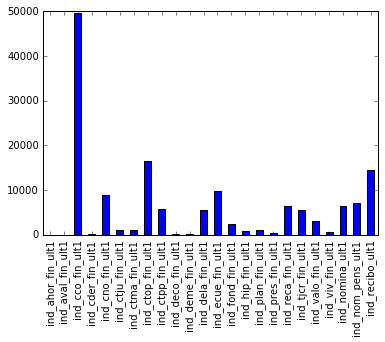

In [288]:
Y[TARGET_LABELS].sum(axis=0).plot.bar()
# plt.figure()
# plt.hist(Y[TARGET_LABELS].values)

In [258]:
# CROSS VALIDATION
from sklearn.preprocessing import StandardScaler


# def dummies_to_decimal(row):
#     output = ''
#     for v in row.values:
#         output += str(int(v))
#     return log(int(output,2)+1)

def prepare_to_fit(X_train, Y_train):
    # Select only active client for the training part
    mask = X_train['diff'] > 0
    X_train_ = X_train[mask]
    y_train = Y_train[mask][TARGET_LABELS].values
    
    x_train = []
    for key in profiles:
        x_train_ = X_train_[profiles[key]].values
        x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train

def prepare_to_fit_nomask(X_train, Y_train):
    y_train = Y_train[TARGET_LABELS].values
    x_train = []
    for key in profiles:
        x_train_ = X_train[profiles[key]].values
        x_train_ = StandardScaler().fit_transform(x_train_)
        x_train.append(x_train_)
    return x_train, y_train

def prepare_to_test(X_val, Y_val=None):
    if Y_val is not None:
        y_val = Y_val[TARGET_LABELS].values
    
    x_val = []
    for key in profiles:
        x_val_ = X_val[profiles[key]].values    
        x_val_ = StandardScaler().fit_transform(x_val_)  
        x_val.append(x_val_)    
    
    if Y_val is not None:
        return x_val, y_val
    else:
        return x_val

def cross_val_score2(data, nb_folds=5, 
                     prepare_to_fit_func=prepare_to_fit, 
                     prepare_to_test_func=prepare_to_test, 
                     create_model_func=create_model):
    
    x_df, y_df, clients_last_choice_df = data
    kf = KFold(n_splits=nb_folds)
    scores = []
    
    for train_index, test_index in kf.split(range(x_df.shape[0])):
        X_train, X_val = x_df.loc[x_df.index[train_index], :], x_df.loc[x_df.index[test_index], :]
        Y_train, Y_val = y_df.loc[y_df.index[train_index], :], y_df.loc[y_df.index[test_index], :]
        CLC_val = clients_last_choice_df.loc[clients_last_choice_df.index[test_index], :]
                
        x_train, y_train = prepare_to_fit_func(X_train, Y_train)
        x_val, y_val = prepare_to_test_func(X_val, Y_val)
        
        logging.info("- Train/Val shapes : {}, {} | {}, {}".format(
                [i.shape for i in x_train] if isinstance(x_train, list) else x_train.shape, 
                [i.shape for i in x_val] if isinstance(x_val, list) else x_val.shape, 
                y_train.shape, 
                y_val.shape)
        )                
            
        logging.info("- Create the model")
        estimator = create_model_func()
        logging.info("- Fit the model")
        hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=2000, verbose=0)        
        for key in hist.history:            
            logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
        
        logging.info("- Predict using trained model")
        y_pred = estimator.predict(x_val, verbose=0)
        logging.info("- Compute map7 score")
        scores.append(map7_score2(y_val, y_pred, CLC_val[TARGET_LABELS].values))        
    
    return np.array(scores)

In [215]:
results = cross_val_score2((X, Y, clients_last_choice), nb_folds=nb_folds)
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

INFO:root:- Train/Val shapes : [(2825, 8), (2825, 5), (2825, 6)], [(14041, 8), (14041, 5), (14041, 6)] | (2825, 24), (14041, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.479100, max=0.862375
INFO:root:-- loss : min=0.273264, max=0.693774
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0464338281428
INFO:root:- Train/Val shapes : [(3123, 8), (3123, 5), (3123, 6)], [(14041, 8), (14041, 5), (14041, 6)] | (3123, 24), (14041, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.585882, max=0.857282
INFO:root:-- loss : min=0.281735, max=0.690641
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0314629181207
INFO:root:- Train/Val shapes : [(3200, 8), (3200, 5), (3200, 6)], [(14041, 8), (14041, 5), (14041, 6)] | (3200, 24), (14041, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc :

Cross-Validation 
 5 | 0.030488 | 0.039801 | 0.056277 | 0.01001 


In [234]:
# young_profile = ['pais_residencia', 'sexo', 'nomprov', 'renta', 'ind_actividad_cliente', 'canal_entrada']
young_profile = ['renta', 'nomprov', 'ind_actividad_cliente']

def prepare_to_fit2(X_train, Y_train):
    # Select only active client for the training part
    mask = X_train['diff'] > 0
    X_train_ = X_train[mask]
    y_train = Y_train[mask][TARGET_LABELS].values    
    
    x_train = X_train_[young_profile].values
    x_train = StandardScaler().fit_transform(x_train)
    return x_train, y_train

def prepare_to_fit3(X_train, Y_train):
    X_train_ = X_train
    y_train = Y_train[TARGET_LABELS].values    
    
    x_train = X_train_[young_profile].values
    x_train = StandardScaler().fit_transform(x_train)
    return x_train, y_train


def prepare_to_test2(X_val, Y_val=None):
    if Y_val is not None:
        y_val = Y_val[TARGET_LABELS].values
    
    x_val = X_val[young_profile].values    
    x_val = StandardScaler().fit_transform(x_val)  
    
    if Y_val is not None:
        return x_val, y_val
    else:
        return x_val


def create_model2():
    ll = len(TARGET_LABELS)
    length = len(young_profile)
    final_model = Sequential()
    final_model.add(Dense(50, init='uniform', input_shape=(length,), activation='relu'))
    final_model.add(Dropout(0.15))
    final_model.add(Dense(40, activation='relu'))
    final_model.add(Dropout(0.15))
    final_model.add(Dense(20, activation='relu'))
    final_model.add(Dropout(0.15))
    final_model.add(Dense(ll, activation='sigmoid'))    
    final_model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return final_model

In [264]:
results = cross_val_score2((X_1, Y_1, clients_last_choice_1), 
                           nb_folds=nb_folds, 
                           prepare_to_fit_func=prepare_to_fit,
                           prepare_to_test_func=prepare_to_test,                           
                           create_model_func=create_model
                          )
print "Cross-Validation \n %i | %f | %f | %f | %.5f " % (nb_folds, results.min(), results.mean(), results.max(), results.std())

INFO:root:- Train/Val shapes : [(265, 5), (265, 5)], [(5899, 5), (5899, 5)] | (265, 24), (5899, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.480031, max=0.925157
INFO:root:-- loss : min=0.161325, max=0.694504
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0177306417284
INFO:root:- Train/Val shapes : [(306, 5), (306, 5)], [(5899, 5), (5899, 5)] | (306, 24), (5899, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.351988, max=0.920207
INFO:root:-- loss : min=0.179947, max=0.698339
INFO:root:- Predict using trained model
INFO:root:- Compute map7 score
INFO:root:-- Predicted map7 score: 0.0109886798139
INFO:root:- Train/Val shapes : [(280, 5), (280, 5)], [(5899, 5), (5899, 5)] | (280, 24), (5899, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.501488, max=0.921726
INFO:root:-- loss : min=0.175361, max=0.693472
INFO:root:- 

Cross-Validation 
 5 | 0.010989 | 0.012816 | 0.017731 | 0.00249 


### Test 4 : Train on active clients + feature engineering

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = max

#### Feature engineering

- age -> age group
- income -> income group
- separate young clients from others due to different train/test distributions


#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=2000

*Cross-validation results :* 

On the others

type | Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
--- | --- | --- | --- | --- | --- | ---
other | 150 | 5 | 0.030910 | 0.040277 | 0.056534 | 0.01018 
young | 150 | 5 | 0.009835 | 0.012245 | 0.016968 | 0.00252 




### Test 3 : Train on active clients

#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = max

#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=2000

*Cross-validation results :* 

Nb epoch | Nb folds | Min MAP@7 | Mean MAP@7 | Max MAP@7 | STD MAP@7
--- | --- | --- | --- | --- | ---
150 | 5 | 0.021769 | 0.030416 | 0.041625 | 0.00679 



#### Data:

- yearmonth_list = [201505, 201506]
- nb_clients = 100000

#### Model

- merged profiles with 'ave', sigmoid, binary_crossentropy, nadam, accuracy, 


**Conf:**
- Profiles : 0, 1, 8
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030864 | 0.00731


**Conf:**
- Profiles : 0, 8 
- batch_size=500

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030895 | 0.00732
500 | 5 | 0.030959 | 0.00776


**Conf:**
- Profiles : 0, 8 
- batch_size=1000

*Cross-validation results :* 

Nb epoch | Nb folds | Mean MAP@7 | STD(MAP@7)
--- | --- | --- | ---
150 | 5 | 0.030885 | 0.00758
500 | 5 | 0.030639 | 0.00769



## Train model for predictions

In [162]:
def train_model(X_train, Y_train):

    x_train, y_train = prepare_to_fit(X_train, Y_train)
    logging.info("- Train data shapes : {}, {}".format(
            [i.shape for i in x_train], 
            y_train.shape)
    )                

    logging.info("- Create the model")
    estimator = create_model()
    logging.info("- Fit the model")
    hist = estimator.fit(x_train, y_train, nb_epoch=150, batch_size=1000, verbose=0)        
    for key in hist.history:            
        logging.info("-- %s : min=%f, max=%f" % (key, np.min(hist.history[key]), np.max(hist.history[key])))
    return estimator

estimator = train_model(X, Y)

INFO:root:- Train data shapes : [(3775, 8), (3775, 5), (3775, 6)], (3775, 24)
INFO:root:- Create the model
INFO:root:- Fit the model
INFO:root:-- acc : min=0.547417, max=0.855706
INFO:root:-- loss : min=0.287112, max=0.691252


Check score on the same data

In [163]:
x_val, y_val = prepare_to_test(X, Y)
y_pred = estimator.predict(x_val, verbose=0)

print "Score on the whole dataset : ", map7_score2(y_val, y_pred, clients_last_choice[TARGET_LABELS].values)


Score on the whole dataset : 

INFO:root:-- Predicted map7 score: 0.0416305338727


 0.0416305338727


## Prediction on test data

In [164]:
#del X, Y, X_train, X_val, Y_train, Y_val, trainval_df, data_df

Load the last month from the training dataset to get user last choice and remove it from predictions

In [300]:
yearmonth_list = [201605]
lastmonth_df = load_data2(TRAIN_FILE_PATH, yearmonth_list)
minimal_clean_data_inplace(lastmonth_df)

test_df = load_data2(TEST_FILE_PATH, [])
minimal_clean_data_inplace(test_df)
preprocess_data_inplace(test_df)
test_df = test_df.sort_values(['ncodpers'])

clients_last_choice_test = lastmonth_df[['ncodpers'] + TARGET_LABELS].sort_values(['ncodpers'])
# Select only clients from test data
clients_last_choice_test = clients_last_choice_test[clients_last_choice_test['ncodpers'].isin(test_df['ncodpers'])]
assert (test_df['ncodpers'] == clients_last_choice_test['ncodpers']).all(), "WTF"

INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10
INFO:root:-- Read all data from the file : ../data/test_ver2.csv
INFO:root:- Number of lines with unknown data : 0
INFO:root:- Number of columns with nan : 10


In [313]:
X_test = test_df[['ncodpers'] + features]

In [314]:
X_test.loc[:,'age'] = X_test['age'].apply(get_age_group_index)
X_test.loc[:,'renta'] = X_test['renta'].apply(get_income_group_index)

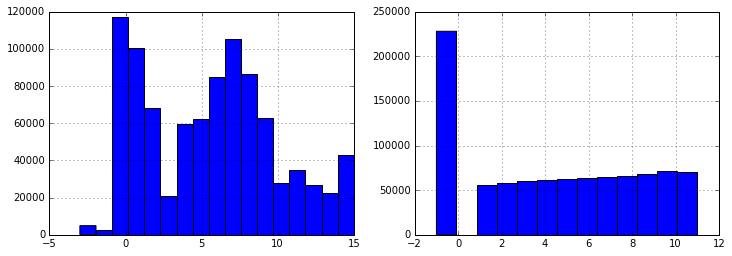

In [315]:
plt.figure(figsize=(12,4))
plt.subplot(121)
X_test['age'].hist(bins=17)
plt.subplot(122)
X_test['renta'].hist(bins=13)

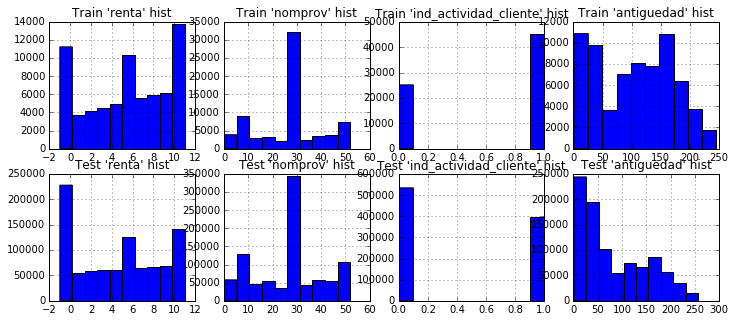

In [338]:
visualize_train_test(X, X_test, young_profiles[0])

Separate young people from others 

In [340]:
mask = X_test['age'].isin([0, 1, 2]) 
mask_clients = X_test[mask]['ncodpers']
X_test_1 = X_test[mask]
X_test_0 = X_test[~mask]
mask = clients_last_choice_test['ncodpers'].isin(mask_clients)
clients_last_choice_test_1 = clients_last_choice_test[mask]
clients_last_choice_test_0 = clients_last_choice_test[~mask]

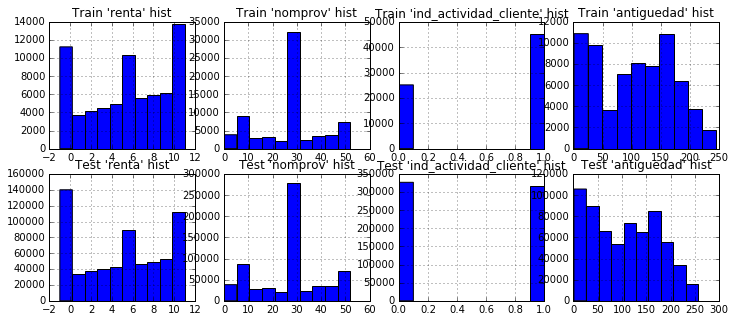

In [343]:
visualize_train_test(X, X_test_0, young_profiles[0])

Make predictions

In [184]:
x_test = prepare_to_test(X_test)
y_pred = estimator.predict(x_test, verbose=0)

def get_submission(y_pred, clients, clc, target_labels, n_highest=7):
    predicted_added_products = np.argsort(y_pred, axis=1)
    predicted_added_products = predicted_added_products[:,::-1][:,:n_highest]
    added_products_col = []
    count = 0 
    for products, last_choice in zip(predicted_added_products, clc):
        predictions = remove_last_choice(products, last_choice)
        added_products_col.append(' '.join([target_labels[i] for i in predictions]))
        count+=1
        if count % 100000 == 0:
            logging.info("Elapsed : %i", count)
            
    out = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
    return out


clients = X_test['ncodpers']
submission = get_submission(y_pred, clients, clients_last_choice_test[TARGET_LABELS].values, TARGET_LABELS, 7)
submission.head()

INFO:root:Elapsed : 100000
INFO:root:Elapsed : 200000
INFO:root:Elapsed : 300000
INFO:root:Elapsed : 400000
INFO:root:Elapsed : 500000
INFO:root:Elapsed : 600000
INFO:root:Elapsed : 700000
INFO:root:Elapsed : 800000
INFO:root:Elapsed : 900000


,ncodpers,added_products
0,15889,ind_recibo_ult1 ind_cno_fin_ult1 ind_nom_pens_...
618359,15890,ind_reca_fin_ult1 ind_cco_fin_ult1
618360,15892,ind_cno_fin_ult1 ind_nom_pens_ult1
618361,15893,ind_recibo_ult1 ind_cno_fin_ult1 ind_nom_pens_...
618362,15894,ind_cno_fin_ult1


In [176]:
# Add missing young clients from X_test_1
# clients = X_test_1['ncodpers']
# added_products_col = [''] * len(clients)
# p2 = pd.DataFrame(data={'ncodpers': clients, 'added_products': added_products_col}, columns=['ncodpers', 'added_products'])
# submission = pd.concat([submission, p2])

Get submission DataFrame and write csv file

In [185]:
from datetime import datetime
import csv

logging.info('- Generate submission')
submission_file = '../results/submission_' + \
                  str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + \
                  '.csv'

submission.to_csv(submission_file, index=False, index_label=False)

INFO:root:- Generate submission
